In [2]:
# Import libraries

import numpy as np
import os
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
import cv2
import pickle
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Tensorflow libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam


In [3]:

# # voc dataset classes 
# voc_labels = {
#     "background": 0,
#     "aeroplane": 1,
#     "bicycle": 2,
#     "bird": 3,
#     "boat": 4,
#     "bottle": 5,
#     "bus": 6,
#     "car": 7,
#     "cat": 8,
#     "chair": 9,
#     "cow": 10,
#     "dining_table": 11,
#     "dog": 12,
#     "horse": 13,
#     "motorbike": 14,
#     "person": 15,
#     "potted_plant": 16,
#     "sheep": 17,
#     "sofa":18,
#     "train":19,
#     "tvmonitor": 20
# }

# filter the classes for training
voc_labels = {
    "background": 0,
    "aeroplane": 1
}


In [4]:
class Args:
    data_dir = "/home/ash/Documents/Personal/Projects/odts/benchmarks/VOC2012"
    # data_dir = "/home/ash/Documents/Projects/VOC2012"
    num_classes = len(voc_labels)
    dropout_rate = 0.35
    learning_rate = 0.0001
    test_size = 0.1
    drop_rate = 0.5
    image_shape = (64,64)
    batch_size = 32
    epochs = 100
    input_shape = (image_shape[0], image_shape[1], 3)   
    optimizer="Adam"
    loss="categorical_crossentropy"
    metrics=["accuracy"]
args=Args()

In [5]:
def getFilepaths(DATA_DIR):
    print("Getting paths for images and corrosponding lables")

    ANNOTATION_DIR = os.path.join(DATA_DIR, "Annotations")
    IMAGES_DIR = os.path.join(DATA_DIR, "JPEGImages")

    annotation_filenames = sorted(os.listdir(ANNOTATION_DIR))
    image_paths = []
    annotation_paths = []
    for num, filename in enumerate(annotation_filenames):
        annotation_path = os.path.join(ANNOTATION_DIR, filename)
        image_filename = filename.split(".")[0]
        image_path = os.path.join(IMAGES_DIR, image_filename + ".jpg")
        image_paths.append(image_path)
        annotation_paths.append(annotation_path)
    assert(len(image_paths) == len(annotation_filenames))
    return image_paths, annotation_paths
image_paths, annotation_paths = getFilepaths(args.data_dir)
print("Images = ", len(image_paths))

Getting paths for images and corrosponding lables
Images =  17125


{'size': (500, 281), 'filename': '2007_000032.jpg', 'objects': [{'aeroplane': [104, 78, 375, 183]}, {'aeroplane': [133, 88, 197, 123]}, {'person': [195, 180, 213, 229]}, {'person': [26, 189, 44, 238]}]}


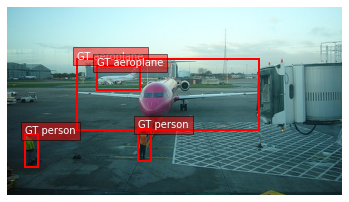

In [6]:

# Parse the xml annotation file and retrieve the path to each image, its size and annotations
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(float(z.find(".//width").text)), int(float(z.find(".//height").text)))
    fname = z.find("./filename").text
    dicts = [
        {
            obj.find("name").text: [
                int(float(obj.find("bndbox/xmin").text)),
                int(float(obj.find("bndbox/ymin").text)),
                int(float(obj.find("bndbox/xmax").text)),
                int(float(obj.find("bndbox/ymax").text)),
            ]
        }
        for obj in objects
    ]
    return {"size": size, "filename": fname, "objects": dicts}


def loadAnnotation(filename):
    annotation = extract_xml_annotation(filename)
    return annotation


def loadImage(filename):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2] - bbox[0] + 1, bbox[3] - bbox[1] + 1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(
        bbox[0],
        bbox[1],
        display_txt,
        color="white",
        bbox={"facecolor": color, "alpha": 0.5},
    )


def plot_annotations(img, prediction=None, ground_truth=None):
    current_axis = plt.gca()
    for object in ground_truth["objects"]:
        obj_class = list(object.keys())[0]
        bbox = list(object.values())[0]
        if ground_truth:
            text = "GT " + obj_class
            patch(current_axis, bbox, text, "red")
        if prediction:
            conf = f'{prediction["confidence"]:0.2f} '
            text = "PRED " + obj_class
            patch(current_axis, bbox, text, "blue")
        plt.axis("off")
    plt.imshow(img)
    plt.show()

idx = 1
image = loadImage(image_paths[idx])
annotation = loadAnnotation(annotation_paths[idx])
print(annotation)
plot_annotations(image, ground_truth=annotation)

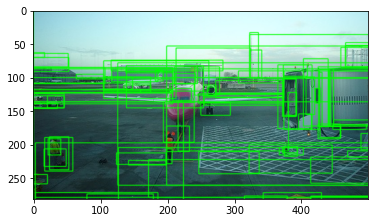

In [91]:
def drawRectangle(image, rectangle):
    x, y, w, h = rectangle
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)


def showRectangles(image, rectangles, first_n):
    for i, rect in enumerate(rectangles):
        # draw reactangles
        drawRectangle(image, rect)
        if i == first_n:
            break
    # Show image
    plt.imshow(image)


def getROI(image, rect):
    x1, y1, x2, y2 = rect
    roi = image[y1:y2, x1:x2]
    return roi


def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    if interArea == boxAArea + boxBArea:
        iou = 1
    else:
        iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


def selectiveSearch(method, image):
    # segmentation
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set the image on which we will run segmentation
    ss.setBaseImage(image)
    # Switch to fast but low recall selective search method
    if method == "fast":
        ss.switchToSelectiveSearchFast()
    elif method == "quality":
        ss.switchToSelectiveSearchQuality()
    else:
        print(__doc__)
        sys.exit(1)
    # process the selective search segmentatation on the image
    rectangles = ss.process()
    # rectangles = rectangles.unique()
    return rectangles[:2000]



cv2.setUseOptimized(True)
cv2.setNumThreads(4)
idx = 1  # random.randint(0, len(images))
image = loadImage(image_paths[idx])
# Set the selective search object class
rectangles = selectiveSearch("fast", image)
# # Show rectangles
showRectangles(image, rectangles, first_n=100)



In [8]:

def roiExtractor(image, annotation, image_shape, voc_labels):
    X = []  #
    y = []  #
    img_classes = [] # all the objec classes in the image
    img_boxes = [] # Corrosponding boxes to the objects

    # Get objects and their respective bounding boxes
    for object in annotation["objects"]:
        obj_class = list(object.keys())[0]
        if obj_class in voc_labels:
            obj_box = list(object.values())[0]
            img_classes.append(obj_class)
            img_boxes.append(obj_box)
    
    # If no objects found in training labels, exit
    if not img_classes:
        return X, y

    max_background_images = 5 * len(img_classes) # get only 5 background images per object
    num_background_images = 0 # counter for bckground images
    
    # Get selective search proposals for the image
    ss_results = selectiveSearch("fast", image)
    background_images = []
    for ss_result in ss_results:
        x1, y1, w, h = ss_result
        ss_box = [x1, y1, x1+w, y1+h]
        
        #Get iou of the ss_box for each object class (filtered) in the image
        iou_list = []
        for idx in range(len(img_classes)):
            iou = bb_intersection_over_union(ss_box, obj_box)
            roi_class = img_classes[idx]
            iou_list.append(iou)

        # Get max of iou and corrosponding label
        iou_max = max(iou_list)
        if iou_max > 0.7:
            # Get the roi and resize it to the input shape of nn
            roi = getROI(image, ss_box) # crop the image
            roi = cv2.resize(roi, (image_shape[0], image_shape[1])) # resize the image
            roi_class = img_classes[iou_list.index(iou_max)]
            roi_label = voc_labels.get(roi_class)
            X.append(roi)
            y.append(roi_label)
        elif iou_max < 0.2 and num_background_images < max_background_images:
            # Get the roi and resize it to the input shape of nn
            roi = getROI(image, ss_box) # crop the image
            roi = cv2.resize(roi, (image_shape[0], image_shape[1])) # resize the image
            background_images.append(roi)
            num_background_images += 1
    # create labels for background images
    background_labels = [0] * len(background_images) # label for background
    X.extend(background_images)
    y.extend(background_labels)
    assert(len(X)==len(y))
    return X, y




{'size': (500, 281), 'filename': '2007_000032.jpg', 'objects': [{'aeroplane': [104, 78, 375, 183]}, {'aeroplane': [133, 88, 197, 123]}, {'person': [195, 180, 213, 229]}, {'person': [26, 189, 44, 238]}]}
{'background': 0, 'aeroplane': 1}


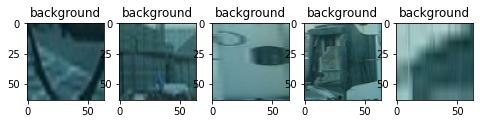

In [9]:
idx = 1
image = loadImage(image_paths[idx])
annotation = loadAnnotation(annotation_paths[idx])
print(annotation)
print(voc_labels)

X_train_roi, y_train_roi = roiExtractor(image, annotation, image_shape=args.image_shape, voc_labels = voc_labels)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[8, 8])
for _, ax in enumerate(axes.flat):
    i = random.randint(0, (len(X_train_roi)-1))
    ax.imshow(X_train_roi[i])
    roi_class = list(voc_labels.keys())[list(voc_labels.values()).index(y_train_roi[i])]
    ax.set_title(roi_class)

In [10]:
from tqdm import tqdm
def createDataset(image_paths, annotation_paths, image_shape, voc_labels):
    images = []
    labels = []
    for idx in tqdm(range(len(image_paths))):
        image = loadImage(image_paths[idx])
        annotation = loadAnnotation(annotation_paths[idx])
        X, y = roiExtractor(image, annotation, image_shape, voc_labels)
        images.extend(X)
        labels.extend(y)
    return images, labels


images, labels = createDataset(image_paths, annotation_paths, args.image_shape, voc_labels)



100%|██████████| 17125/17125 [12:14<00:00, 23.32it/s] 


In [11]:
X = np.array(images)
print(labels[0:5])
y = np.array(labels)
y = tf.keras.utils.to_categorical(labels, len(voc_labels))
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=args.test_size, random_state=42)

print("Training images = ", len(X_train))
print("Test images = ", len(X_test))
print(X_train.shape)
print(y_train.shape)

[1, 0, 0, 0, 0]
Training images =  11750
Test images =  1306
(11750, 64, 64, 3)
(11750, 2)


In [12]:
# Training data generator
trdata = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
# Tests data generator
tsdata = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False, vertical_flip=False, rotation_range=0)
testdata = tsdata.flow(x=X_test, y=y_test)

In [13]:
# For Keras
config = tf.compat.v1.ConfigProto()
# dynamically grow the memory used on the GPU
# to log device placement (on which device the operation ran)
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
# set this TensorFlow session as the default session for Keras
tf.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [14]:
# Get the backbone model i.e. vgg16
class Backbone:
    """Get the VGG network as a backbone."""

    def __init__(
        self,
        arch,
        include_top,
        weights,
        input_shape,
        trainable,
    ):

        self.arch = arch
        self.include_top = include_top
        self.weights = weights
        self.input_tensor = None
        self.input_shape = input_shape
        self.pooling = None
        self.classes = 1000
        self.trainable = trainable

    def vgg16(self):
        return tf.keras.applications.VGG16(
            include_top=self.include_top,
            weights=self.weights,
            input_tensor=self.input_tensor,
            input_shape=self.input_shape,
            pooling=self.pooling,
            classes=self.classes,
        )

    def vgg19(self):
        return tf.keras.applications.VGG19(
            include_top=self.include_top,
            weights=self.weights,
            input_tensor=self.input_tensor,
            input_shape=self.input_shape,
            pooling=self.pooling,
            classes=self.classes,
        )

    def resnet50(self):
        return tf.keras.applications.ResNet50(
            include_top=self.include_top,
            weights=self.weights,
            input_tensor=self.input_tensor,
            input_shape=self.input_shape,
            pooling=self.pooling,
            classes=self.classes,
        )

    def resnet101(self):
        return tf.keras.applications.ResNet101(
            include_top=self.include_top,
            weights=self.weights,
            input_tensor=self.input_tensor,
            input_shape=self.input_shape,
            pooling=self.pooling,
            classes=self.classes,
        )

    def densenet121(self):
        return tf.keras.applications.DenseNet121(
            include_top=self.include_top,
            weights=self.weights,
            input_tensor=self.input_tensor,
            input_shape=self.input_shape,
            pooling=self.pooling,
            classes=self.classes,
        )

    def mobilenetV2(self):
        return tf.keras.applications.MobileNetV2(
            include_top=self.include_top,
            weights=self.weights,
            input_tensor=self.input_tensor,
            input_shape=self.input_shape,
            pooling=self.pooling,
            classes=self.classes,
        )

    def backboneModel(self):
        if self.arch == "vgg16":
            model = self.vgg16()
        elif self.arch == "vgg19":
            model = self.vgg19()
        elif self.arch == "resnet50":
            model = self.resnet50()
        elif self.arch == "resnet101":
            model = self.resnet101()
        elif self.arch == "densenet121":
            model = self.densenet121()
        elif self.arch == "mobilenetV2":
            model = self.mobilenetV2()
        else:
            print("Invalid architecture")
            sys.exit(1)

        model.trainable = self.trainable
        return model

arch = "densenet121"
include_top = True
weights = "imagenet"
input_shape = (224, 224, 3)
trainable = False
optimizer = "Adam"
loss = "categorical_crossentropy"
metrics = ["accuracy"]


# Get the backbone model eg. vgg16, densenet121 etc
backbone = Backbone(
    arch="vgg16",
    include_top=False,
    weights="imagenet",
    input_shape=args.input_shape,
    trainable=False,
)
backbone_model = backbone.backboneModel()
backbone_model.compile(optimizer, loss, metrics)
backbone_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [15]:
def Model(backbone_model, output_classes, dropout_rate):

    model = Sequential()
    model.add(backbone_model)
    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_classes, activation="softmax"))
    return model

## Create model

# Get the sequential model with trainable head
model = Model(backbone_model=backbone.backboneModel(), output_classes=args.num_classes, dropout_rate=args.dropout_rate)
# Compile the model
model.compile(
    optimizer=args.optimizer,
    loss=args.loss,
    metrics=args.metrics,
)

# Publish the model summary
model.summary()







Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 14,985,346
Trainable params: 270,658
Non-trainable params: 14,714,688
______________________________________

In [16]:
# checkpoints for saving the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5",
    verbose=1,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

# Train the model
model.fit(traindata,
        steps_per_epoch=len(X_train) // args.batch_size,
        epochs=10,#args.epochs,
        callbacks=[checkpoint,early],
        validation_data=testdata,
        verbose=1, shuffle=True)

model.save("final_model")


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 367 steps, validate for 41 steps
Epoch 1/10
366/367 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.8965
Epoch 00001: val_loss improved from inf to 0.20537, saving model to model.h5
367/367 [==============================] - 28s 75ms/step - loss: 0.4793 - accuracy: 0.8967 - val_loss: 0.2054 - val_accuracy: 0.9242
Epoch 2/10
365/367 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9359
Epoch 00002: val_loss improved from 0.20537 to 0.16493, saving model to model.h5
367/367 [==============================] - 23s 62ms/step - loss: 0.1804 - accuracy: 0.9357 - val_loss: 0.1649 - val_accuracy: 0.9349
Epoch 3/10
365/367 [============================>.] - ETA: 0s - loss: 0.1641 - accuracy: 0.9417
Epoch 00003: val_loss did not improve from 0.16493
367/367 [==============================] - 15s 41ms/step - loss: 0.1647 - accuracy: 0.9417 - val_loss: 0.1654 - val_accuracy: 0.9364
Epoch 4/10


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# For Keras
config = tf.compat.v1.ConfigProto()
# dynamically grow the memory used on the GPU
# to log device placement (on which device the operation ran)
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
# set this TensorFlow session as the default session for Keras
tf.compat.v1.keras.backend.set_session(sess)

def get_model(path, input_shape):
    model = tf.keras.models.load_model(path)
    model.build(input_shape)
    model.summary()
    return model

model_path = "/media/ash/AK/rcnn/final_model"
input_shape = (None, 64, 64, 3)
model = get_model(model_path, input_shape)


                   

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  262272    
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dropout (Dropout)   

In [71]:

# Parse the xml annotation file and retrieve the path to each image, its size and annotations
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(float(z.find(".//width").text)), int(float(z.find(".//height").text)))
    fname = z.find("./filename").text
    dicts = [
        {
            obj.find("name").text: [
                int(float(obj.find("bndbox/xmin").text)),
                int(float(obj.find("bndbox/ymin").text)),
                int(float(obj.find("bndbox/xmax").text)),
                int(float(obj.find("bndbox/ymax").text)),
            ]
        }
        for obj in objects
    ]
    return {"size": size, "filename": fname, "objects": dicts}


def loadAnnotation(filename):
    annotation = extract_xml_annotation(filename)
    return annotation


def loadImage(filename):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2] - bbox[0] + 1, bbox[3] - bbox[1] + 1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(
        bbox[0],
        bbox[1],
        display_txt,
        color="white",
        bbox={"facecolor": color, "alpha": 0.5},
    )

def plot_annotations(img, prediction=None, ground_truth=None):
    current_axis = plt.gca()
    for object in ground_truth["objects"]:
        obj_class = list(object.keys())[0]
        bbox = list(object.values())[0]
        if ground_truth:
            text = "GT " + obj_class
            patch(current_axis, bbox, text, "red")
        if prediction:
            conf = f'{prediction["confidence"]:0.2f} '
            text = "PRED " + obj_class
            patch(current_axis, bbox, text, "blue")
        plt.axis("off")
    plt.imshow(img)
    plt.show()

# Malisiewicz et al.
def non_max_suppression_fast(boxes, probs, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by probablities
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")


def get_pred(image):
    roi = cv2.resize(image, (64, 64)) # resize the image
    roi = np.asarray(roi, dtype='float32')
    pred = model.predict(roi.reshape((1, 64, 64, 3)))
    # list out keys and values separately
    key_list = list(voc_labels.keys())
    val_list = list(voc_labels.values())

    idx = np.argmax(pred)
    prob = np.max(pred)
    roi_class = val_list.index(idx)
    roi_label = key_list[roi_class]
    return roi_label, roi_class, prob

class DictList(dict):
    def __init__(self):
        super().__init__()
    def __setitem__(self, key, value):
        try:
            # Assumes there is a list on the key
            self[key].append(value)
        except KeyError: # If it fails, because there is no key
            super(DictList, self).__setitem__(key, value)
        except AttributeError: # If it fails because it is not a list
            super(DictList, self).__setitem__(key, [self[key], value])

In [8]:
import tensorflow as tf
from utils import *
from voc2012 import *

class Args:
    def __init__(self, data_dir, num_classes, dropout_rate, learning_rate, test_size, image_shape, batch_size, epochs, optimizer, loss, metrics):
        self.data_dir = data_dir
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_shape = (image_shape[0], image_shape[1], 3)
        self.optimizer=optimizer
        self.loss=loss
        self.metrics=metrics


if __name__ == '__main__':
    # get trainewd labels
    voc_labels = get_labels(filtered=True)

    
    # Create arguments
    data_dir = "/home/ash/Documents/Personal/Projects/odts/benchmarks/VOC2012"
    #data_dir = "/home/ash/Documents/Projects/VOC2012"

    # data_dir = "/home/ash/Documents/Projects/VOC2012"
    num_classes = len(voc_labels)
    dropout_rate = 0.35
    learning_rate = 0.0001
    test_size = 0.1
    drop_rate = 0.5
    image_shape = (64,64)
    batch_size = 32
    epochs = 100
    input_shape = (image_shape[0], image_shape[1], 3)
    optimizer="Adam"
    loss="categorical_crossentropy"
    metrics=["accuracy"]

    args = Args(data_dir, num_classes, dropout_rate, learning_rate, test_size, image_shape, batch_size, epochs, optimizer, loss, metrics)
    
    #Load tthe pre-trained model
    model = get_model("/media/ash/AK/rcnn/final_model", (None, 64, 64, 3))

    # Get image and annotation file paths
    image_paths, annotation_paths = getFilepaths(args.data_dir)
    
        
    


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  262272    
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  130       
Total params: 14,985,346
Trainable params: 270,658
Non-trainable params: 14,714,688
______________________________________

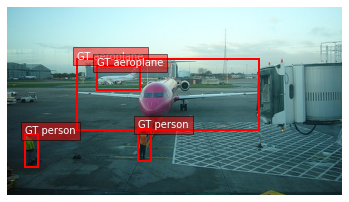

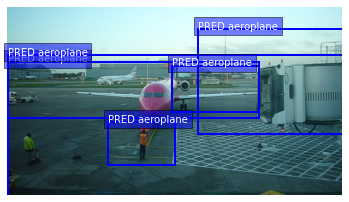

In [186]:

# Test image
idx = 1
image = loadImage(image_paths[idx])
annotation = loadAnnotation(annotation_paths[idx])
#print(annotation)
plot_annotations(image, ground_truth=annotation)

# Selective search on the image
cv2.setUseOptimized(True)
cv2.setNumThreads(4)
# Set the selective search object class
ss_results = selectiveSearch("fast", image)
# # Show rectangles
showRectangles(image.copy(), ss_results, first_n=100)
predictions = DictList()
for ss_result in ss_results:
    x1, y1, w, h = ss_result
    ss_box = [x1, y1, x1+w, y1+h]

    # Get the roi of the box
    roi = getROI(image, ss_box) # crop the image
    roi_label, roi_class, prob = get_pred(roi)
    if roi_class:
        predictions[roi_label] = ss_box, prob

keys  = list(predictions.keys())
for key in keys:
    values = predictions[key]
    boxes = []
    probs = []
    for i in range(len(values)):
        boxes.append(values[i][0])
        probs.append(values[i][1])
    overlapThresh=0.5
    boxes = np.stack(boxes, axis=0)
    probs = np.stack(probs, axis=0)
#     non_max_boxes = non_max_suppression_fast(boxes, probs, overlapThresh)
    non_max_boxes = non_max_suppression_fast(boxes, probs, overlapThresh)
    obj_class = key
    plot_predictions(image, key, non_max_boxes)

In [185]:
def plot_predictions(image, obj_class, non_max_boxes):
    current_axis = plt.gca()
    for box in non_max_boxes:
        text = "PRED " + obj_class
        patch(current_axis, box, text, "blue")
    #     print(box)
        plt.axis("off")
    plt.imshow(image)
    plt.show()